<a href="https://colab.research.google.com/github/ZeynebBechiri/ZeynebBechiri-fcc_predict_health_costs/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.python.feature_column import feature_column

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-03-14 19:56:17--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0s      

2022-03-14 19:56:18 (111 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


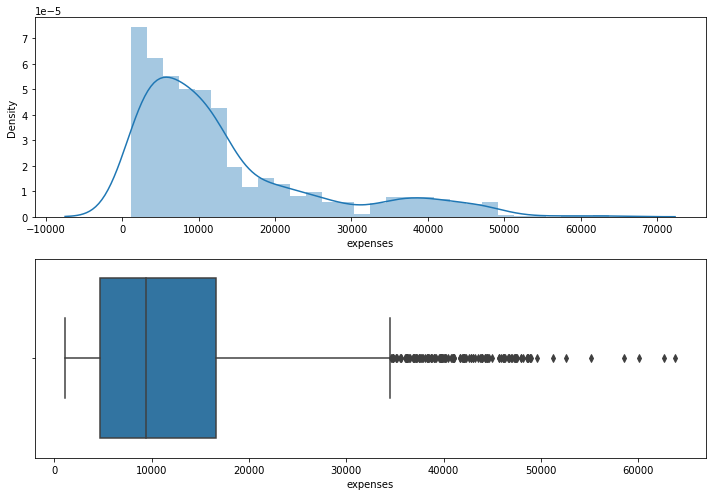

In [3]:
# Visualizing expenses
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(dataset['expenses'])
fig.add_subplot(2,1,2)
sns.boxplot(dataset['expenses'])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

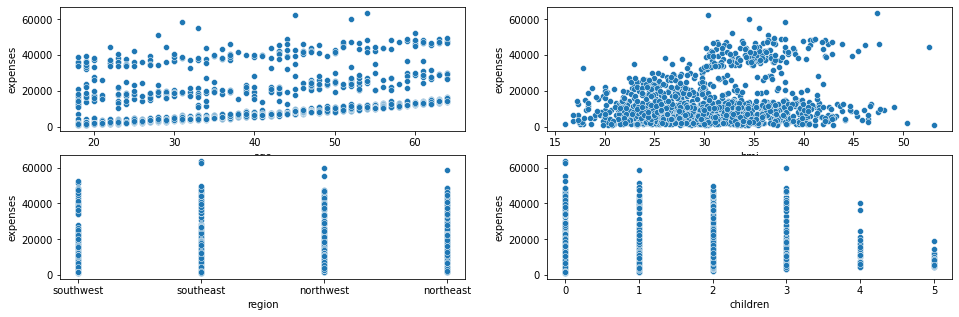

In [4]:
# Visualizing age, bmi, sex, region, children
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(dataset['age'], dataset['expenses'])
fig.add_subplot(2,2,2)
sns.scatterplot(dataset['bmi'],dataset['expenses'])
fig.add_subplot(2,2,3)
sns.scatterplot(dataset['region'],dataset['expenses'])
fig.add_subplot(2,2,4)
sns.scatterplot(dataset['children'],dataset['expenses'])

In [5]:
# Check if there are any Null values
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [6]:
# Categorical data conversion
CATEGORICAL_COLUMNS = ['sex','smoker','region']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dataset[feature_name].unique()  # gets a list of all unique values from given feature column
  dataset[feature_name].replace(vocabulary,list(range(0, len(vocabulary))), inplace=True)

In [7]:
# Split data
train_dataset, test_dataset = np.split(dataset, [int(0.8*len(dataset))])
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

train_dataset.info()
train_dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   int64  
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   int64  
 5   region    1070 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 50.3 KB


,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.551402,14.141959,18.0,27.0,40.0,51.750,64.0
sex,1070.0,0.510280,0.500128,0.0,0.0,1.0,1.000,1.0
bmi,1070.0,30.784953,6.085046,16.0,26.4,30.5,34.975,52.6
children,1070.0,1.075701,1.191986,0.0,0.0,1.0,2.000,5.0
smoker,1070.0,0.799065,0.400887,0.0,1.0,1.0,1.000,1.0
region,1070.0,1.484112,1.107517,0.0,1.0,1.0,2.000,3.0


In [8]:
# Building the model
model = keras.Sequential([
    keras.layers.Input(shape=(len(train_dataset.keys()),)),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1)
]
)

In [9]:
tf.keras.utils.plot_model

<function keras.utils.vis_utils.plot_model>

In [10]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 6) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
dense (None, 6) float32
dense_1 (None, 64) float32
dense_2 (None, 64) float32


[None, None, None]

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['mae','mse'])
# Train the model
model.fit(train_dataset, train_labels, epochs=500)

9/9 - 0s - loss: 25238464.0000 - mae: 3105.7910 - mse: 25238464.0000 - 124ms/epoch - 14ms/step
Testing set Mean Abs Error: 3105.79 expenses
You passed the challenge. Great job!


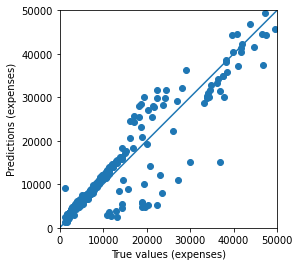

In [12]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
